

# **TASK 1 - GO EMOTIONS**
---

# **IMPORT DEPENDENCIES AND CHECKING**

In [19]:
!pip install transformers datasets evaluate accelerate scikit-learn matplotlib seaborn

In [20]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from torch.nn import BCEWithLogitsLoss, Sigmoid

# ------------------------------------------------------------------
# BAGIAN 1: SETUP & CONFIG
# ------------------------------------------------------------------
# Cek GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Konfigurasi
MODEL_CKPT = "bert-base-uncased"
BATCH_SIZE = 8 # Sesuaikan dengan RAM GPU (8/16 aman untuk Colab)
EPOCHS = 3
LEARNING_RATE = 2e-5
MAX_LENGTH = 128
SAMPLE_SIZE = 3000  # Ambil sebagian data agar training cepat (Hapus ini jika mau full dataset)



Device: cuda


# **LOAD DATASET**


In [21]:
# ------------------------------------------------------------------
# BAGIAN 2: LOAD DATASET & LABEL MAPPING
# ------------------------------------------------------------------
print("\n--- Loading Dataset ---")
dataset = load_dataset("google-research-datasets/go_emotions", "simplified")

# Ambil daftar nama label (emosi)
labels_list = dataset["train"].features["labels"].feature.names
NUM_LABELS = len(labels_list)

# Buat mapping ID <-> Label
id2label = {idx: label for idx, label in enumerate(labels_list)}
label2id = {label: idx for idx, label in enumerate(labels_list)}

print(f"Total Labels: {NUM_LABELS}")
print(f"Labels: {labels_list}")

# (Opsional) Sampling data agar cepat
train_dataset = dataset["train"].shuffle(seed=42).select(range(SAMPLE_SIZE))
eval_dataset = dataset["validation"].shuffle(seed=42).select(range(SAMPLE_SIZE // 5))



--- Loading Dataset ---
Total Labels: 28
Labels: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


# **TOKENISASI**

In [22]:
# ------------------------------------------------------------------
# BAGIAN 3: PREPROCESSING (MULTI-LABEL HANDLING)
# ------------------------------------------------------------------
print("\n--- Tokenizing & Formatting Labels ---")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def preprocess_function(examples):
    # 1. Tokenisasi teks
    text = examples["text"]
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LENGTH)

    # 2. Ubah format Label menjadi Multi-Hot Encoding (Array 0 dan 1)
    # Contoh: Labels [0, 2] pada 4 kelas menjadi [1, 0, 1, 0]
    labels_matrix = np.zeros((len(text), NUM_LABELS), dtype=float) # Pastikan tipe float
    for idx, label_indices in enumerate(examples["labels"]):
        labels_matrix[idx, label_indices] = 1

    # Explicitly convert to torch.float tensor
    encoding["labels"] = torch.tensor(labels_matrix, dtype=torch.float)
    return encoding

# Terapkan ke dataset
encoded_train = train_dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
encoded_eval = eval_dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)

# Set format ke PyTorch Tensor (ini akan bekerja dengan lebih baik karena labels sudah float tensor)
encoded_train.set_format("torch")
encoded_eval.set_format("torch")



--- Tokenizing & Formatting Labels ---


In [23]:
# ------------------------------------------------------------------
# BAGIAN 4: METRICS (KHUSUS MULTI-LABEL)
# ------------------------------------------------------------------
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Karena multi-label, output model adalah Logits. Kita perlu Sigmoid.
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.tensor(predictions))

    # Gunakan threshold 0.5 (jika probabilitas > 50%, anggap label aktif)
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= 0.5)] = 1

    # Hitung F1 Score (Micro average cocok untuk ketidakseimbangan kelas)
    f1_micro = f1_score(labels, y_pred, average="micro")

    return {"f1_micro": f1_micro}

# **LOAD PRE-TRAINED MODEL & TRAIN CONFIG**

In [24]:
from transformers import DataCollatorWithPadding

# Custom Data Collator untuk memastikan labels bertipe float
class CustomDataCollatorWithPadding(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        # Ensure labels are float for BCEWithLogitsLoss
        if "labels" in batch:
            batch["labels"] = batch["labels"].to(torch.float)
        return batch

# ------------------------------------------------------------------
# BAGIAN 5: LOAD MODEL & TRAINING CONFIG
# ------------------------------------------------------------------
print("\n--- Loading Model ---")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification", # Penting agar loss function otomatis pakai BCEWithLogitsLoss
    id2label=id2label,
    label2id=label2id
)
model.to(device)

training_args = TrainingArguments(
    output_dir="./bert-goemotions-results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_steps=50, # Catat log setiap 50 step untuk grafik nanti
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_eval,
    tokenizer=tokenizer,
    data_collator=CustomDataCollatorWithPadding(tokenizer=tokenizer), # Use custom data collator
    compute_metrics=compute_metrics,
)



--- Loading Model ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-224063962.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# **TRAINING**


--- Starting Training ---


Epoch,Training Loss,Validation Loss,F1 Micro
1,0.152100,0.151152,0.025105
2,0.138600,0.141845,0.147316
3,0.135500,0.139172,0.244898



--- Saving Model ---

--- Visualizing Training History ---


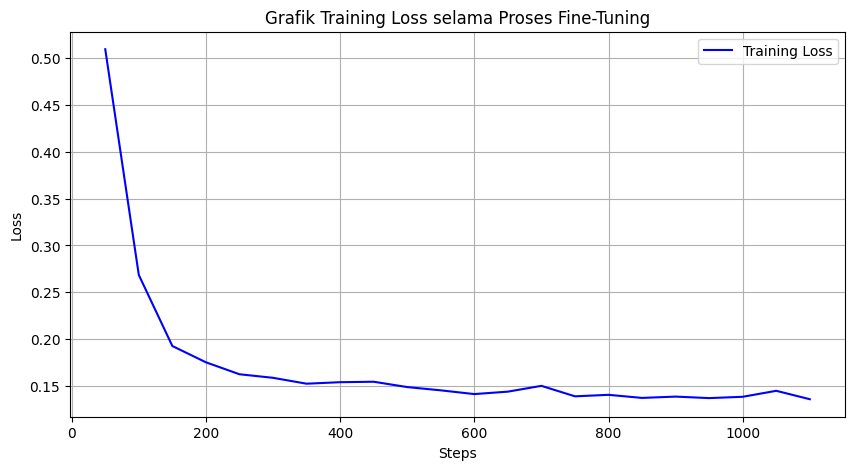

In [25]:
# ------------------------------------------------------------------
# BAGIAN 6: TRAINING PROCESS
# ------------------------------------------------------------------
print("\n--- Starting Training ---")
train_result = trainer.train()

# Simpan Model Akhir
print("\n--- Saving Model ---")
trainer.save_model("./my_emotion_model")
tokenizer.save_pretrained("./my_emotion_model")

# ------------------------------------------------------------------
# BAGIAN 7: VISUALISASI PROSES TRAINING (LOSS)
# ------------------------------------------------------------------
print("\n--- Visualizing Training History ---")
# Mengambil log history dari trainer
history = trainer.state.log_history

# Ekstrak data loss
steps = []
losses = []
for entry in history:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss", color="blue")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Grafik Training Loss selama Proses Fine-Tuning")
plt.legend()
plt.grid(True)
plt.show()

# **FINE TUNED INFERENCED METHOD**

In [26]:
# ------------------------------------------------------------------
# BAGIAN 8: INFERENCE & VISUALISASI HASIL PREDIKSI
# ------------------------------------------------------------------
print("\n--- Inference (Testing Model) ---")

def predict_emotion(text, model, tokenizer, device):
    # 1. Siapkan teks
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 2. Prediksi
    with torch.no_grad():
        outputs = model(**inputs)

    # 3. Proses Logits -> Sigmoid -> Probabilitas
    logits = outputs.logits
    probs = torch.sigmoid(logits).cpu().numpy()[0] # Array 28 angka (0.0 - 1.0)

    return probs

# --- CONTOH PENGGUNAAN ---
text_sample = "I am so happy that I finally got the promotion, but a bit nervous about the new responsibility."
print(f"Input Text: '{text_sample}'")

# Load model yang sudah disimpan (Simulasi production)
saved_model = AutoModelForSequenceClassification.from_pretrained("./my_emotion_model").to(device)
saved_tokenizer = AutoTokenizer.from_pretrained("./my_emotion_model")

# Prediksi
probabilities = predict_emotion(text_sample, saved_model, saved_tokenizer, device)



--- Inference (Testing Model) ---
Input Text: 'I am so happy that I finally got the promotion, but a bit nervous about the new responsibility.'


# **VISUALISASI**


Top Predicted Emotions:
- admiration: 0.2181
- love: 0.1281
- gratitude: 0.1142
- approval: 0.1056
- amusement: 0.0901


/tmp/ipython-input-659448504.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_labels, palette="viridis")


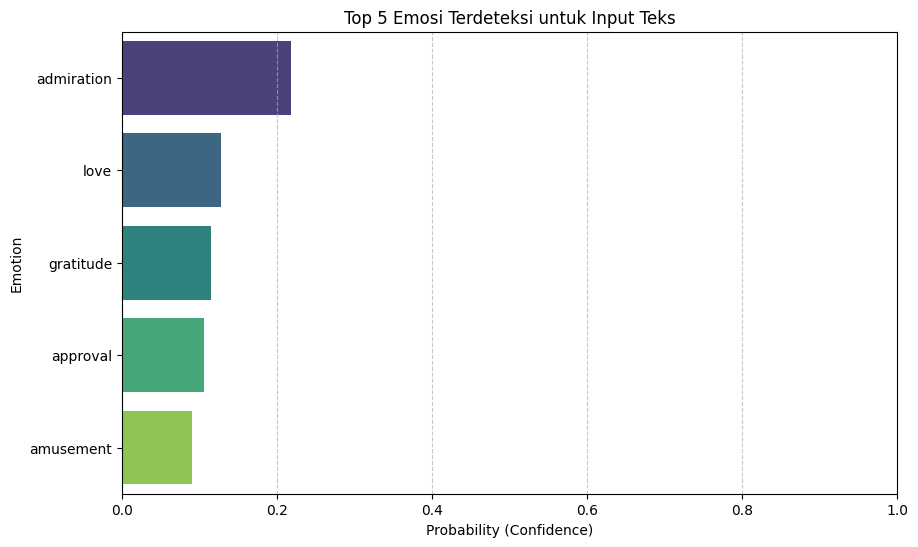

In [27]:

# Visualisasi Grafik Batang (Bar Chart) Probabilitas
# Kita ambil Top 5 Emosi Tertinggi agar grafik rapi
top_k = 5
top_indices = probabilities.argsort()[-top_k:][::-1] # Urutkan dari terbesar
top_probs = probabilities[top_indices]
top_labels = [id2label[idx] for idx in top_indices]

# Print hasil teks
print("\nTop Predicted Emotions:")
for label, prob in zip(top_labels, top_probs):
    print(f"- {label}: {prob:.4f}")

# Plot Grafik
plt.figure(figsize=(10, 6))
sns.barplot(x=top_probs, y=top_labels, palette="viridis")
plt.xlabel("Probability (Confidence)")
plt.ylabel("Emotion")
plt.title(f"Top {top_k} Emosi Terdeteksi untuk Input Teks")
plt.xlim(0, 1) # Batas probabilitas 0 sampai 1
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()